In [1]:
import os, sys, pprint, time

import numpy as np
import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import *

from skimage.transform import resize
from matplotlib.pyplot import imshow, imread

from keras.applications import vgg19
import matplotlib.pyplot as plt

%matplotlib inline

/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/peter/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [45]:
iterations = 50
iteration_counter = 20
learning_rate = .1
decay_rate = 1.
beta1 = 0.9
alpha = 10. # weight of the content weight
TV_scaling = 2e-3 #weight of the total variation loss
width = 128
height = 128
c_dim =3 # Dimension of image color
result_path = "./result.png" #path of the result
content_path = "./SL.jpg" # path of the content image
style_path = "./style.jpg"# path of the content image
batchsize = 1


In [3]:
class vgg_net():
    def __init__(self, shape, var_dict=None):
        self.vgg = vgg19.VGG19(include_top=False,input_shape=shape)
        layers = self.vgg.layers
        self.layer_dict = {}
        if var_dict is None:
            for layer in self.vgg.layers:
                layer.trainable=False
                if 'conv' in layer.name:
                    name = layer.name+'_kernel'
                    weights = layer.get_weights()[0]
                    init = tf.constant_initializer(weights)
                    self.layer_dict[name] = tf.get_variable(name, shape = weights.shape, initializer = init, trainable=False)
                    
                    name = layer.name+'_bias'
                    weights = layer.get_weights()[1]
                    init = tf.constant_initializer(weights)
                    self.layer_dict[name] = tf.get_variable(name, shape = weights.shape, initializer = init, trainable=False)
        else:
            self.layer_dict = var_dict
    def conv(self,x, weights, bias):
        y = tf.nn.conv2d(x, filter = weights, strides = [1,1,1,1],padding = 'SAME')
        y = tf.nn.bias_add(y, bias)
        z = tf.nn.relu(y)
        return y,z
    def features(self,x):
        y = 255*x
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=y)
        y = tf.concat(axis=3, values=[blue - 123.68,green - 116.779,red - 103.939])
        outputs = []
        for layer in self.vgg.layers:
            if 'conv' in layer.name:
                feature,y = self.conv(y,self.layer_dict[layer.name + '_kernel'],self.layer_dict[layer.name + '_bias'])
                outputs.append(feature/255.)
            if 'pool' in layer.name:
                y = tf.nn.max_pool(y, ksize=[1,2, 2,1], strides=[1,2,2,1], padding='SAME')
        return outputs
def content_loss_func(features_x, features_y):
    features = list(zip(features_x, features_y))
    loss = 0
    for fx,fy in features:
        loss += tf.losses.mean_squared_error(fx,fy)/2.
    return loss
def style_loss_func(Grams_x, Grams_y):
    Grams = list(zip(Grams_x, Grams_y))
    loss = 0
    for Gram_x,Gram_y in Grams:
        loss += tf.losses.mean_squared_error(Gram_x, Gram_y)/4.
    return loss
def Gram(features):
    Grams = []
    for feature in features:
        tensors = tf.split(feature, num_or_size_splits = feature.shape.as_list()[0])
        gram = []
        for t in tensors:
            gram.append(compute_gram(t))
        Grams.append(tf.stack(gram))
    return Grams
def compute_gram(x):
    y = tf.squeeze(x)
    shape = tf.shape(y)
    y = tf.reshape(y,[tf.reduce_prod(shape[:2]),-1])
    z = tf.matmul(y,y,transpose_a=True)/tf.to_float(tf.reduce_prod(shape[:2]))
    return z

In [4]:
var_dict = None
#    to speed up the computation, we compute the features of the content and style pictures first
content_shape = [width,height]
content_image = np.expand_dims(resize(imread(content_path), content_shape), axis=0).astype(float)
if len(content_image.shape)==3:
    content_image = np.tile(content_image, [3,1,1])
    content_image = np.transpose(content_image, [1,2,0])
    content_image = np.expand_dims(content_image, axis=0)
if content_image.max()>254.:
    content_image = content_image/255.   
style_image = np.expand_dims(imread(style_path).astype(float), 0)
if style_image.max()>254.:
    style_image = style_image/255.
    
# with tf.device('/GPU:0'):
content_shape = content_shape + [c_dim,]

vgg = vgg_net(content_shape, var_dict)
var_dict = vgg.layer_dict

style_shape = style_image.shape[1:]
vgg_style = vgg_net(style_shape, var_dict)

content = tf.placeholder(tf.float32, [1,] + content_shape, name='content')
style = tf.placeholder(tf.float32, [1,None, None]+[c_dim,], name='style')

content_features = vgg.features(content)

style_features = vgg_style.features(style)
Grams_style = Gram(style_features)

/home/peter/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    CF, GS = sess.run([content_features, Grams_style], feed_dict = {content: content_image, style: style_image})
    sess.close()

In [17]:
#    once this is done, we can introduce the image proper and optimize it
image_shape = [batchsize,]+content_shape
im_var = tf.Variable(tf.random_normal(image_shape), name='image', trainable=True)
scale = 1.1
image = scale*tf.nn.sigmoid(im_var) - ((scale-1)/2.)*tf.ones_like(im_var)
image = tf.clip_by_value(image, 0.,1.)

image_features_content = vgg.features(image)
image_features_style = vgg.features(image)
grams_image = Gram(image_features_style)

CF_const = []
GS_const = []
for feature, gram in list(zip(CF, GS)):
    x,y = tf.constant(feature), tf.constant(gram)
    multiples = tf.convert_to_tensor([batchsize, 1,1,1])
    x = tf.tile(x, multiples)
    multiples = tf.convert_to_tensor([batchsize, 1,1])
    y = tf.tile(y, multiples)
    CF_const.append(x)
    GS_const.append(y)

# we follow the original Gatys et al. paper which used specific layers:
# content_loss = content_loss_func(CF_const[9:10],image_features_content[9:10])
content_loss = content_loss_func(CF_const[11:12],image_features_content[11:12])
style_loss = style_loss_func([GS_const[2],GS_const[4],GS_const[8],GS_const[12]],  
                             [grams_image[2],grams_image[4],grams_image[8],grams_image[12]])

# let's add a total variation loss to keep things smooth, otherwise we have an unappealing patchwork of bright colours
TV_loss = tf.image.total_variation(image)

# summaries for tensorboard, if needed:
# with tf.name_scope('summaries/'):
#     tf.summary.scalar('log_loss', tf.log(loss))
#     tf.summary.scalar('log_content', tf.log(content_loss))
#     tf.summary.scalar('log_style', tf.log(style_loss))
#     tf.summary.image('image', image)
#     tf.summary.image('content', tf.constant(content_image))
#     tf.summary.image('style', tf.constant(style_image))
# merged = tf.summary.merge_all()

In [46]:
loss = np.sqrt(alpha)*content_loss + style_loss/np.sqrt(alpha) + TV_scaling*TV_loss

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = learning_rate
decay_rate = decay_rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,decay_steps = 1e3, decay_rate = decay_rate, staircase=False)

optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(loss, var_list = [im_var,], global_step = global_step)

In [47]:
losses = np.zeros([iterations, 2])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
#        # if a tensorboard log is needed, uncomment  the following lines and the ones in the iteration loop      
#        logs_dir = './logs/'
#        tl.files.exists_or_mkdir(logs_dir)
#        
#        #creates the tensorboard log writer
#        writer = tf.summary.FileWriter(logs_dir, graph=tf.get_default_graph())
    print('initializing style transfer')
    iter_counter = 0
    start_time = time.time()
    for iteration in range(iterations):
        # train the network and generate summary statistics for tensorboard
        _ = sess.run(optim)
        loss0, loss1 = sess.run([content_loss, style_loss])
        losses[iteration,0]=loss0
        losses[iteration,1]=loss1
        if iteration%iteration_counter==0:
            print("iteration: [%3d/%3d]" % (iteration, iterations))
            elapsed_time = time.time()-start_time
            print(elapsed_time)
    imgs = sess.run(image)
#     tl.visualize.save_image(np.squeeze(img), result_path)

initializing style transfer
iteration: [  0/ 50]
0.8133523464202881
iteration: [ 20/ 50]
2.480092763900757
iteration: [ 40/ 50]
4.127484083175659


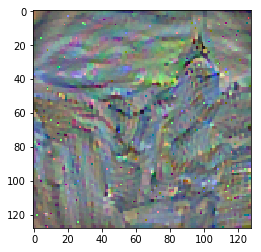

In [48]:
x = imgs[0,:,:,:].squeeze()
x = (x-x.min())/(x.max()-x.min())
imshow(x)
plt.show()

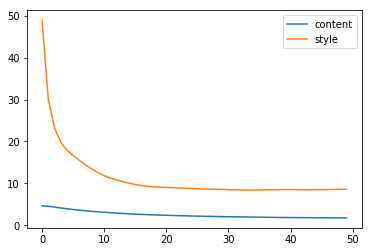

In [44]:
plt.plot(losses)
plt.legend(['content', 'style'])